# 3D random point cloud

In this example we will see how permaviss works in a torus. 
We start by taking a sample of 1000 points from a 3 dimensional unit cube. Since this sample is too big, we take a subsample of 150 points by using a minmax method. We store it in `point_cloud`.

In [1]:
import matplotlib.pyplot as plt
import numpy as np

In [2]:
import scipy.spatial.distance as dist

from permaviss.sample_point_clouds.examples import random_cube, take_sample

X = random_cube(1000,3)
point_cloud = take_sample(X,91)

Dist = dist.squareform(dist.pdist(point_cloud))

## Vietoris Rips complex

Now, we compute the Vietoris Rips complex of `point_cloud`. But before we need to import some functions from **permaviss**.

In [4]:
from permaviss.simplicial_complexes.vietoris_rips import vietoris_rips
from permaviss.simplicial_complexes.differentials import complex_differentials
from permaviss.persistence_algebra.PH_classic import persistent_homology

We set the parameter `max_dim` for the maximum dimension and  `max_r` for the maximum radius of the Vietoris-Rips complex produced from `point_cloud`.

In [5]:
max_r = 0.39
max_dim = 4


C, R = vietoris_rips(Dist, max_r, max_dim)

## Compute ordinary Persistent Homology

Afterwards, we compute the complex differentials using arithmetic mod `p`, a prime number.
Then we get the persistent homology of `point_cloud` with the specified parameters. We store the result in `PerHom`. 

In [6]:
from permaviss.persistence_algebra.PH_classic import persistent_homology

p = 5

Diff = complex_differentials(C, p)
PerHom, _, _ = persistent_homology(Diff, R, max_r, p)

## Now, do the same computation using the Mayer-Vietoris spectral sequence

Now we will proceed to compute again persistent homology of `point_cloud` using the Persistence Mayer-Vietoris spectral sequence instead. For this task we take the same parameters `max_r`, `max_dim` and `p` as before. Let us first import **create_MV_ss**. 

In [7]:
from permaviss.spectral_sequence.MV_spectral_seq import create_MV_ss

We set `max_div`, which is the number of divisions along the coordinate with greater range in `point_cloud`, to be 2. This will indicate **create_MV_ss** to cover `point_cloud` by 8 hypercubes. Also, we set the `overlap` between neighbouring regions to be slightly greater than `max_r`. The method **create_MV_ss** prints the ranks of the computed pages and returns a spectral sequence object which we store in `MV_ss`. This will take a couple of minutes.

In [8]:
max_div = 2
overlap = max_r*1.01

MV_ss = create_MV_ss(point_cloud, max_r, max_dim, max_div, overlap, p)

PAGE: 1
[[  0   0   0   0   0   0   0   0   0]
 [ 11   1   0   0   0   0   0   0   0]
 [ 91  25   0   0   0   0   0   0   0]
 [208 231 236 227 168  84  24   3   0]]
PAGE: 2
[[ 0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0]
 [67  3  0  0  0  0  0  0  0]
 [91  7  2  0  0  0  0  0  0]]
PAGE: 3
[[ 0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0]
 [65  3  0  0  0  0  0  0  0]
 [91  7  1  0  0  0  0  0  0]]
PAGE: 4
[[ 0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0]
 [65  3  0  0  0  0  0  0  0]
 [91  7  1  0  0  0  0  0  0]]
PAGE: 5
[[ 0  0  0  0  0  0  0  0  0]
 [10  0  0  0  0  0  0  0  0]
 [65  3  0  0  0  0  0  0  0]
 [91  7  1  0  0  0  0  0  0]]


Notice that there might appear nontrivial differentials on the second page. 
Now, we compare the computed persistent homology barcodes by both methods. Unless an `AssertError` comes up, this means that the computed barcodes **coincide**. Also, we plot the relevant barcodes. 

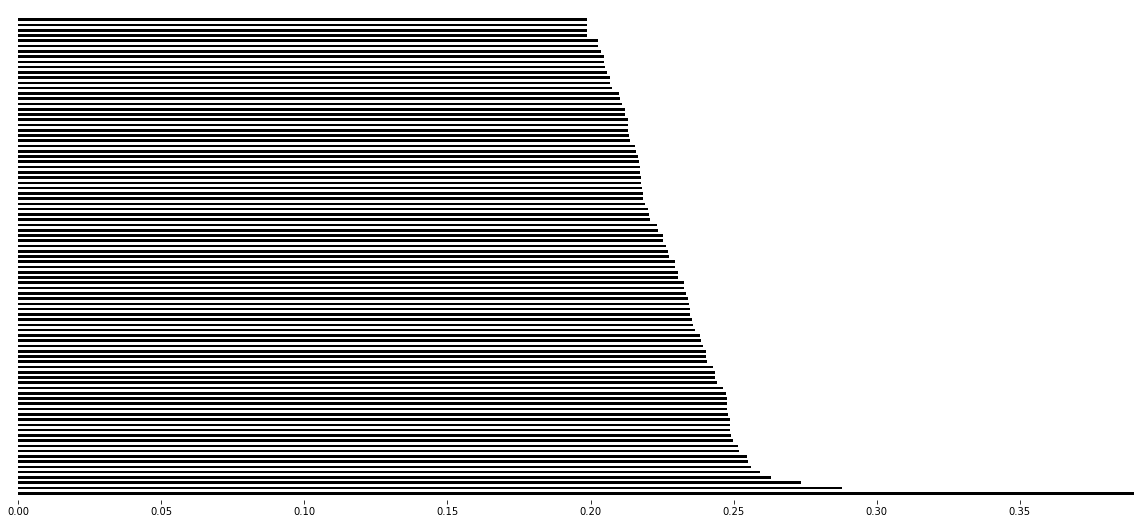

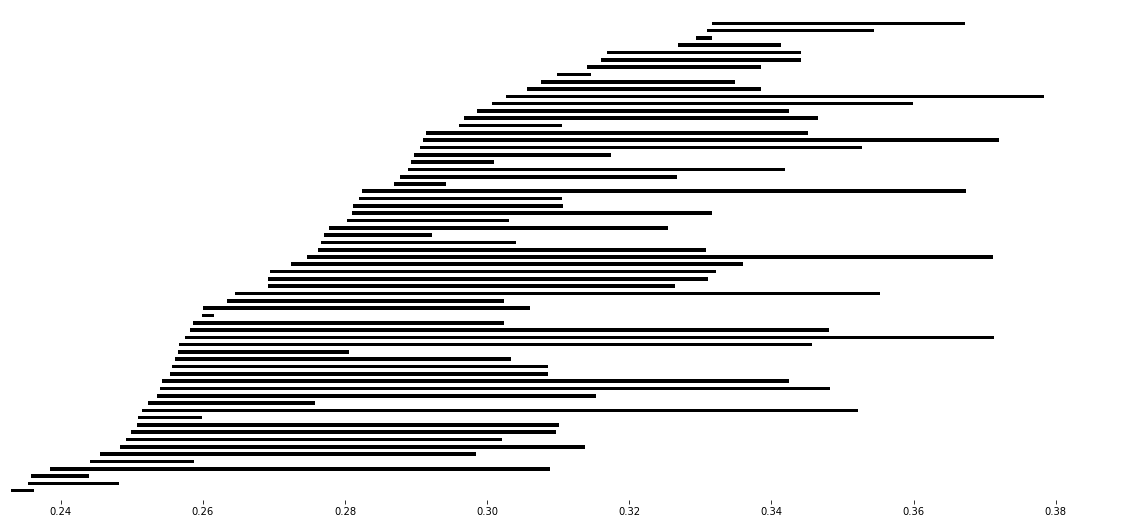

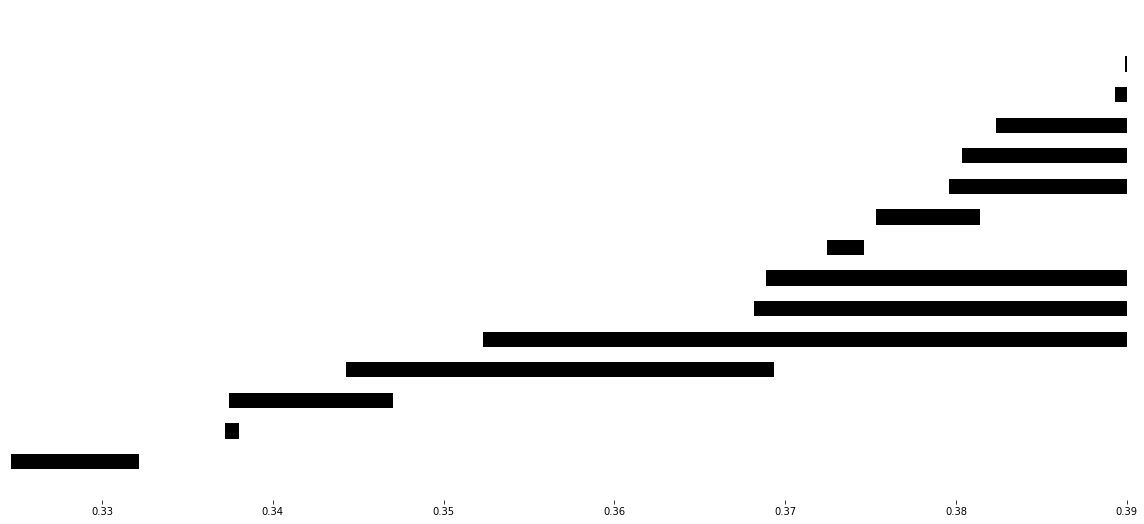

In [11]:
for it, PH in enumerate(MV_ss.persistent_homology):
    # print(PH.barcode)
    min_r = min(PH.barcode[0,:])
    assert np.array_equal(PH.barcode, PerHom[it].barcode)
    step = max_r/PH.dim
    width = step / 2.
    fig, ax = plt.subplots(figsize = (20,9))
    ax = plt.axes(frameon=False)
    y_coord = 0
    # Plot barcodes
    for k, b in enumerate(PH.barcode):
        ax.fill([b[0],b[1],b[1],b[0]],[y_coord,y_coord,y_coord+width,y_coord+width],'black',label='H0')
        y_coord += step
  

    # Show figure 
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlim([min_r,max_r])
    ax.set_ylim([-step, max_r + step])
    plt.savefig("barcode_r{}.png".format(it))
    plt.show()

## Extended bars

Here we look at the extension information on one dimensional persistence classes. For this we exploit the extra information stored in `MV_ss`. What we do is plot the one dimensional barcodes, highlighting those bars from the ``(0,1)`` position in the infinity page in red. Also, we highlight in blue when these bars are extended by a bar in the ``(1,0)`` position on the infinity page. All the black bars are only comming from classes in the ``(1,0)`` position on the infinity page. Similarly, we also highlight the bars on the second diagonal positions ``(2,0)``, ``(1,1)``, ``(0,2)`` by colors yellow, read and blue respectively. If a bar is not extended we write it in black (bars which are not extended are completely contained in ``(0,2)``. 

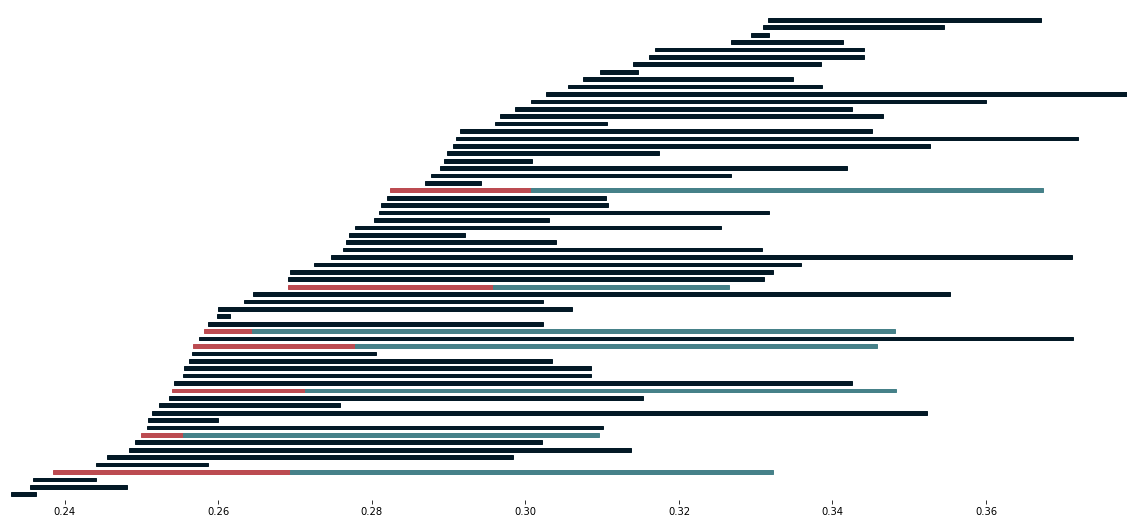

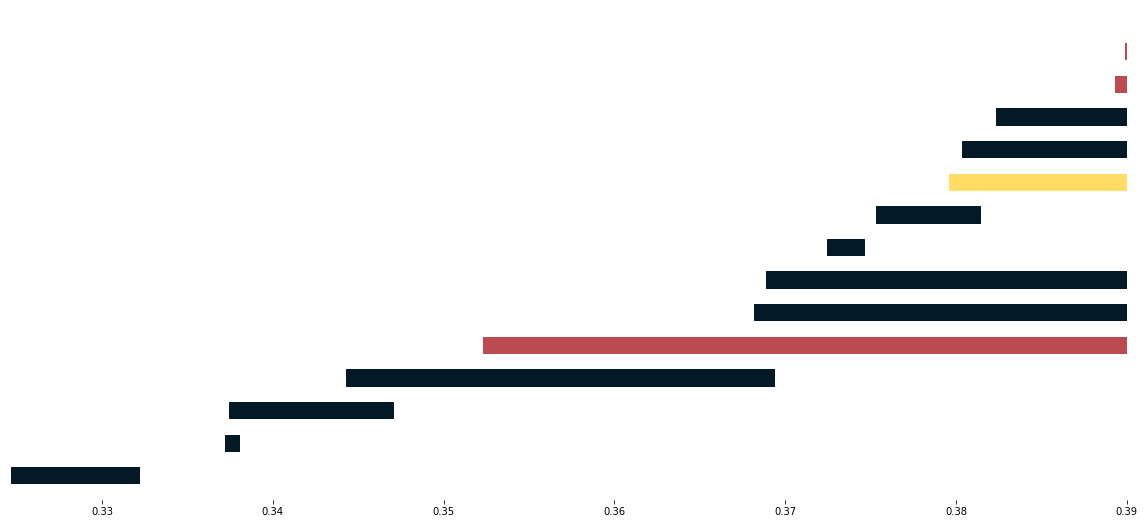

In [10]:
PH = MV_ss.persistent_homology
no_diag = 3
colors = [ "#ffdd66", "#bc4b51", "#468189"]
for diag in range(1, no_diag):
    start_rad = min(PH[diag].barcode[:,0])
    end_rad = max(PH[diag].barcode[:,1])
    persistence = end_rad - start_rad
    fig, ax = plt.subplots(figsize = (20,9))
    ax = plt.axes(frameon=False)
    # ax = plt.axes()
    step = (persistence /2) / PH[diag].dim
    width = (step/6.)
    y_coord = 0
    for b in PH[diag].barcode:
        current_rad = b[0]
        for k in range(diag + 1):
            if k == diag and current_rad == b[0]:
                break
            if len(MV_ss.Hom[MV_ss.no_pages - 1][diag - k][k].barcode) != 0:
                for i, rad in enumerate(MV_ss.Hom[
                        MV_ss.no_pages - 1][diag - k][k].barcode[:,0]):
                    if np.allclose(rad, current_rad):
                        next_rad = MV_ss.Hom[
                            MV_ss.no_pages - 1][diag - k][k].barcode[i,1]
                        ax.fill([current_rad, next_rad, next_rad, current_rad],
                                [y_coord,y_coord,y_coord+step,y_coord+step],
                                c=colors[k + no_diag - diag - 1])
                        current_rad = next_rad
                    # end if
                # end for
            # end if

        # end for
        if current_rad < b[1]:
            ax.fill([current_rad, b[1], b[1], current_rad],
                            [y_coord,y_coord,y_coord+step,y_coord+step],
                            c="#031926")
        # end if    
        y_coord = y_coord + 2 * step
    # end for

    # Show figure
    ax.axes.get_yaxis().set_visible(False)
    ax.set_xlim([start_rad, end_rad])
    ax.set_ylim([-step, y_coord + step])
    plt.show()